In [20]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [21]:
#Creating Graph from folders

graphs = []
labels = []

for i in range(1,5):
    path = os.getcwd() + '/graphsmallds/' + str(i) + '/'
    G,label = createGraph.createGraph(path)
    graphs.append(G)
    labels.append(label)
    
# Convert the list to a Categorical object
cat_label = pd.Categorical(labels, categories=[0,1])

# Create a Pandas Series object from the Categorical object
graph_labels = pd.Series(cat_label)

In [22]:
print(len(graph))
print(graph_labels)

4
0    0
1    0
2    0
3    0
dtype: category
Categories (2, int64): [0, 1]


# Tensorflow

In [23]:
generator = PaddedGraphGenerator(graphs=graphs)

In [24]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model


In [35]:
epochs = 200  # maximum number of training epochs
folds = 2  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [36]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [37]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [38]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [39]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...


2023-03-14 23:51:42.750606: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training and evaluating on fold 2 out of 10...
Training and evaluating on fold 3 out of 10...
Training and evaluating on fold 4 out of 10...
Training and evaluating on fold 5 out of 10...
Training and evaluating on fold 6 out of 10...
Training and evaluating on fold 7 out of 10...
Training and evaluating on fold 8 out of 10...
Training and evaluating on fold 9 out of 10...
Training and evaluating on fold 10 out of 10...


In [40]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)


Accuracy over all folds mean: 1e+02% and std: 0.0%


Text(0, 0.5, 'Count')

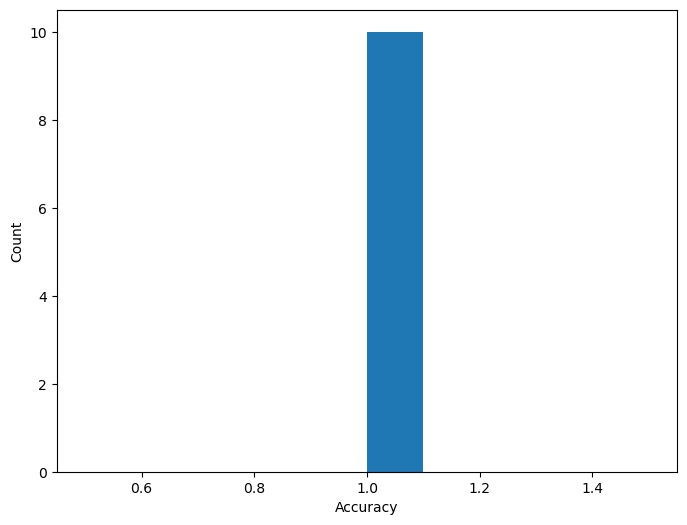

In [41]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")